### Setting Up

In [2]:
# Import all the required libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# from PIL import Image
from IPython.display import display, Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [ ]:
# # get codeium
# import sys
# !{sys.executable} -m pip install -U pip --user
# !{sys.executable} -m pip install -U codeium-jupyter --user
# !jupyter nbextension install --py codeium --user
# !jupyter nbextension enable --py codeium --user
# !jupyter serverextension enable --py codeium --user

In [4]:
# Set the path to the data directory
data_path = './chest_xray'

### Data Exploration

- Explore and check the sanity of the data
- There's no specific image-wise annotations, we can use the folder name as the class name. Or we can see all the images in one folder and then specify which image path belongs to which class
- Result: the images come in different sizes, must make sure they are preprocessed to have the same dimension before feeding to the model


In [6]:
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

In [7]:
# Extract the images and loacted their paths
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

# Use the above function to get the images filenames 
files_list_normal_train = get_list_files(os.path.join(data_path, 'train', CLASS_NAMES[0]))
files_list_pneu_train = get_list_files(os.path.join(data_path, 'train', CLASS_NAMES[1]))
files_list_normal_test = get_list_files(os.path.join(data_path, 'test', CLASS_NAMES[0]))
files_list_pneu_test = get_list_files(os.path.join(data_path, 'test', CLASS_NAMES[1]))

In [8]:
print(f"Number of train samples in Normal category: {len(files_list_normal_train)}")
print(f"Number of train samples in Pneu category: {len(files_list_pneu_train)}")
print(f"Number of test samples in Normal category: {len(files_list_normal_test)}")
print(f"Number of test samples in Pneu category: {len(files_list_pneu_test)}")

Number of train samples in Normal category: 1349
Number of train samples in Pneu category: 3883
Number of test samples in Normal category: 234
Number of test samples in Pneu category: 390


(1380, 1766)


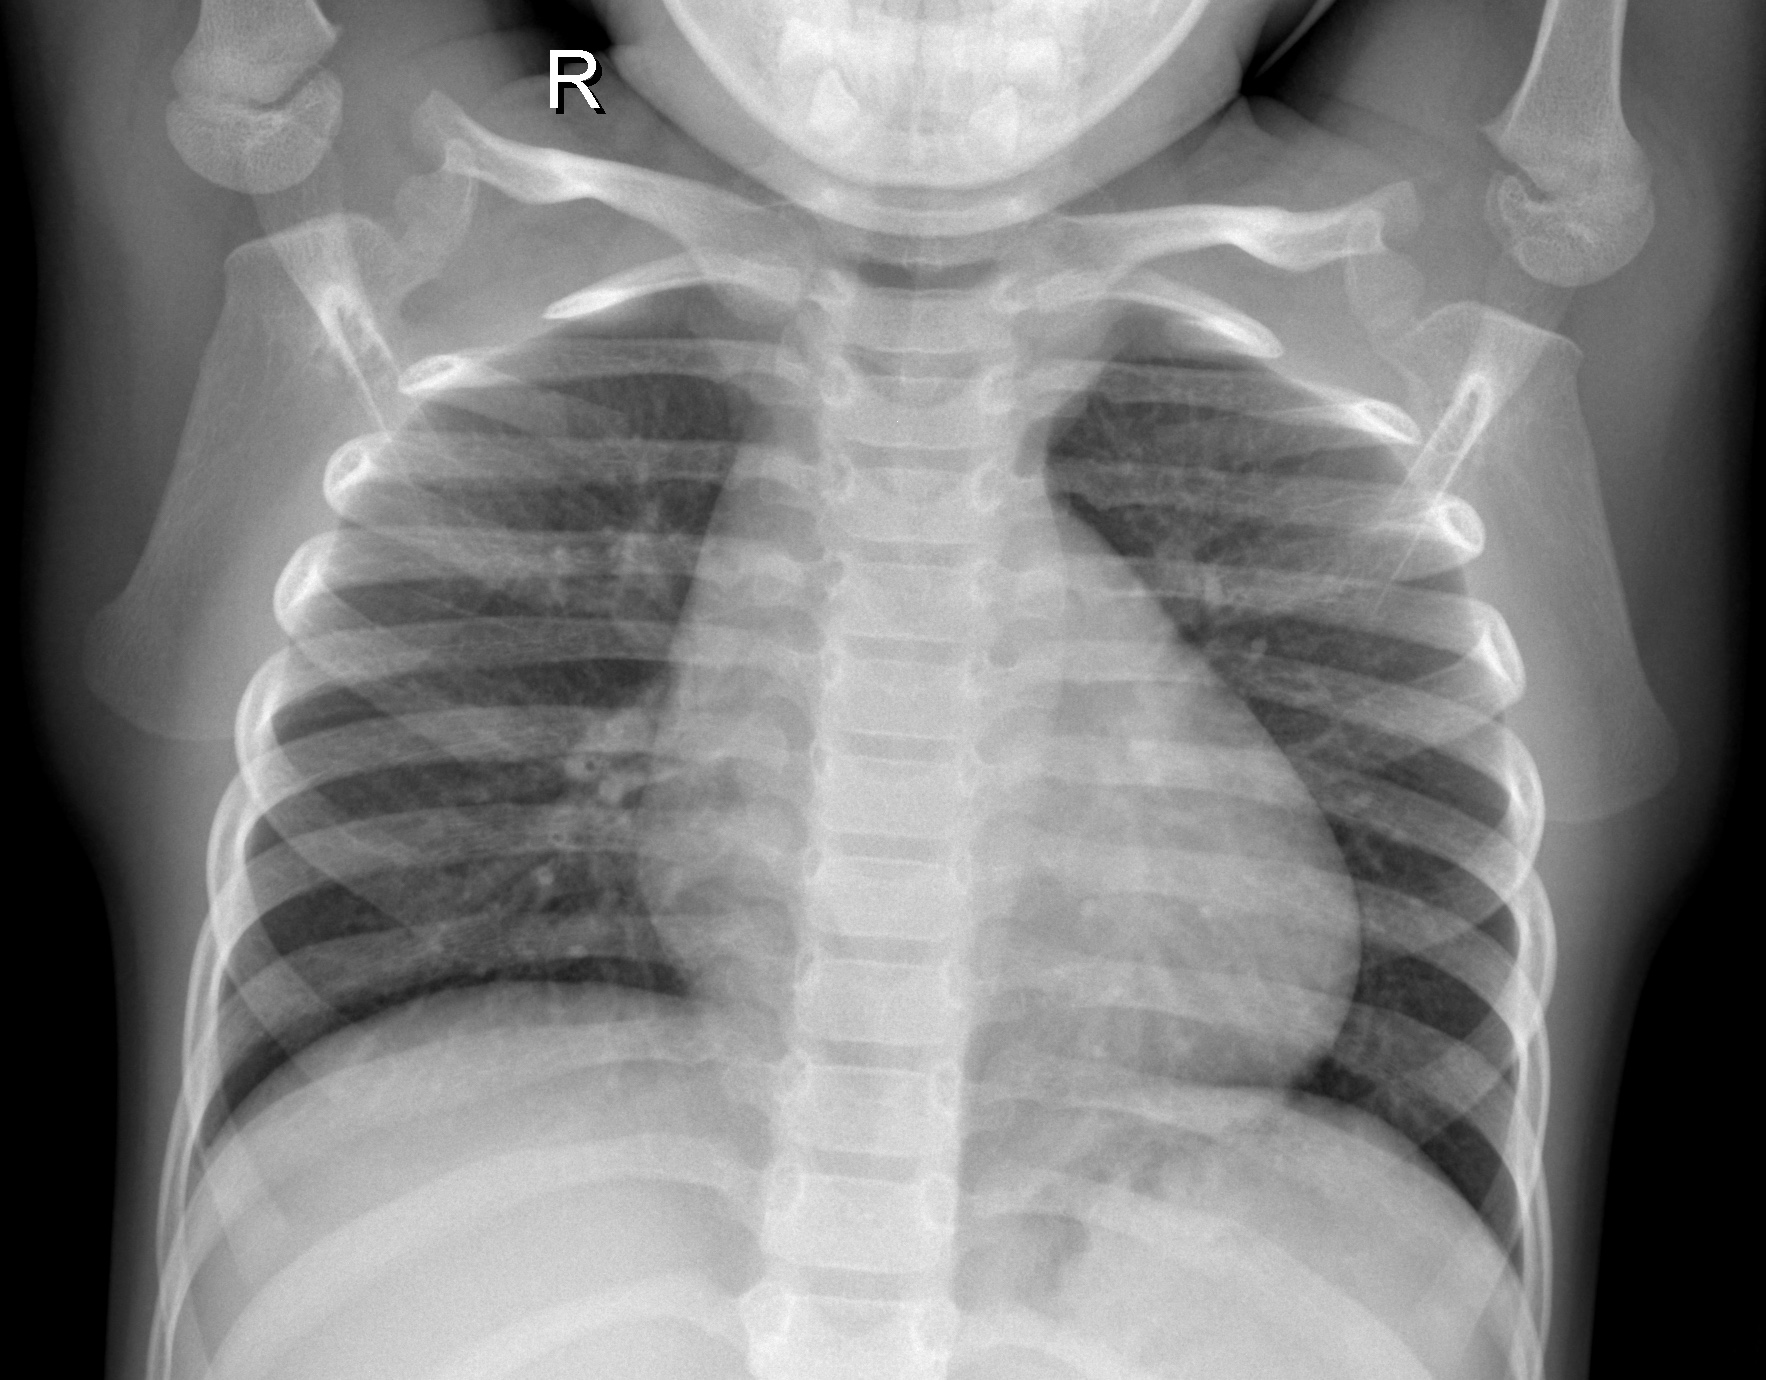

In [9]:
# View Random Image of Normal lung
img_normal = os.path.join(data_path, 'train', CLASS_NAMES[0], files_list_normal_train[np.random.randint(0, len(files_list_normal_train))])
print(plt.imread(img_normal).shape)
display(Image(filename=img_normal))

(1164, 1574)


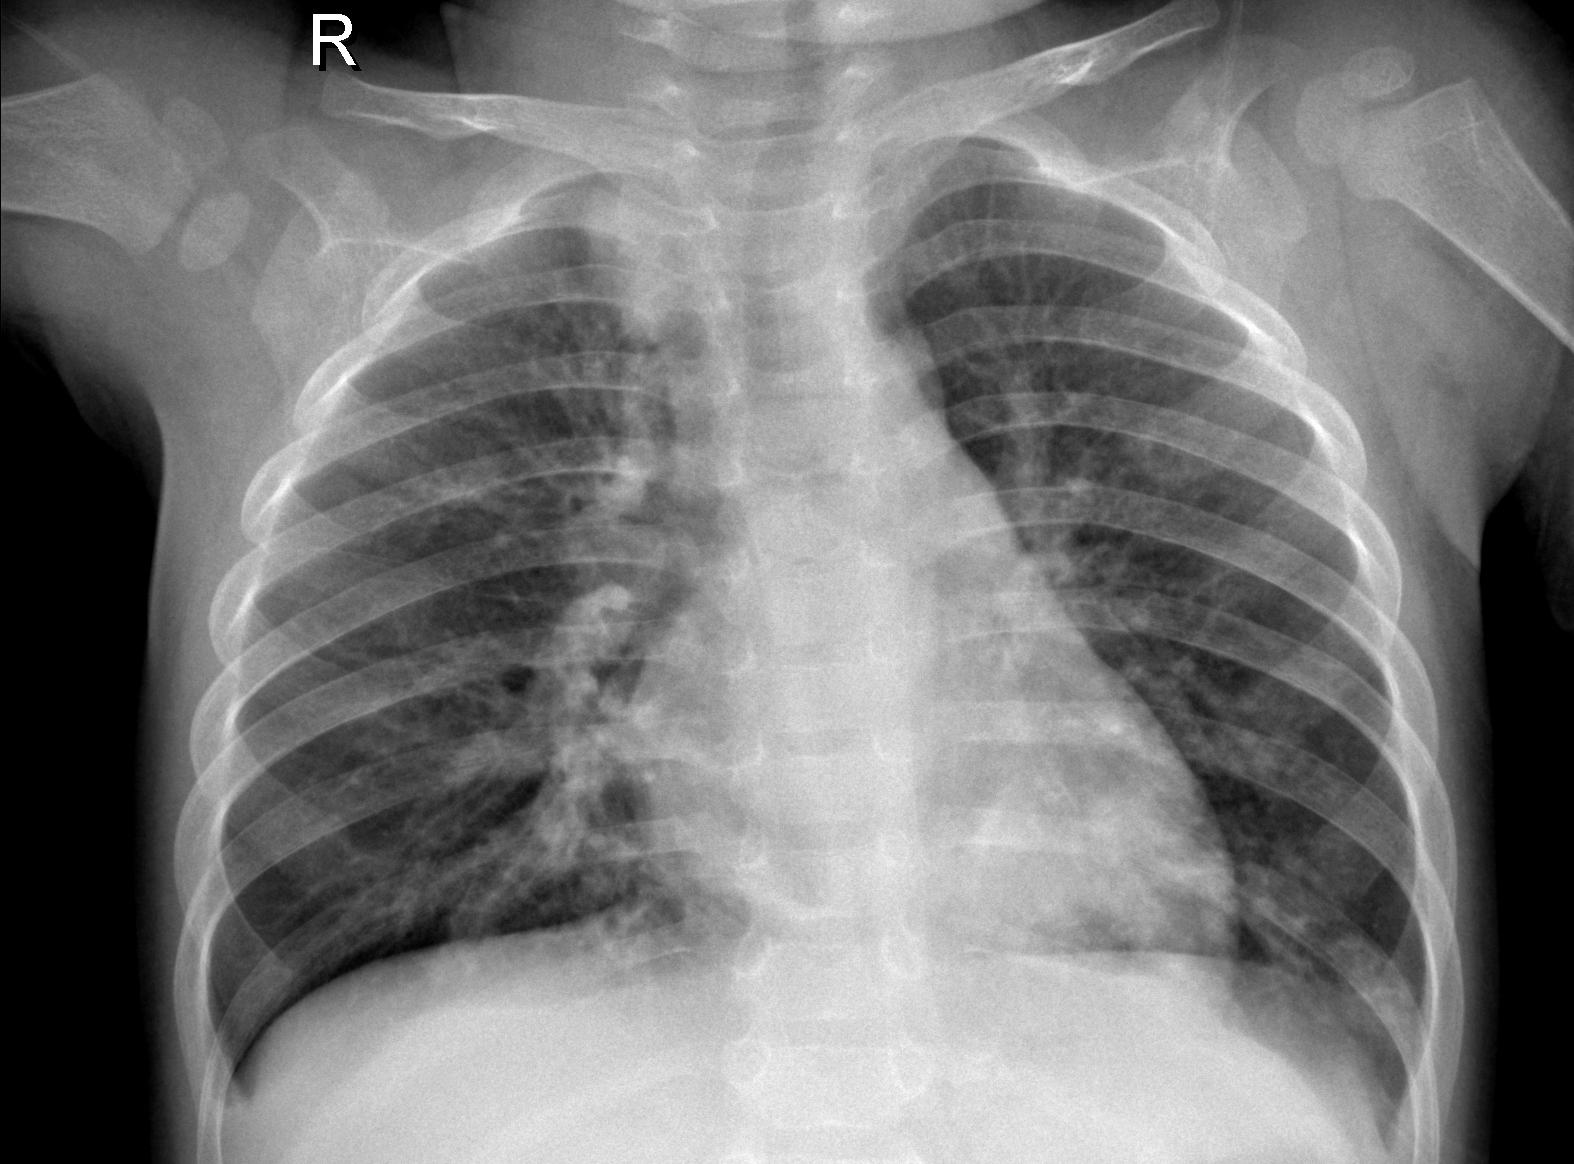

In [10]:
# View random image of Pneumonia lung
pneu_image_location = os.path.join(data_path, 'train', CLASS_NAMES[1], files_list_pneu_train[np.random.randint(0, len(files_list_pneu_train))])
print(plt.imread(pneu_image_location).shape)
display(Image(filename=pneu_image_location))

### Data Loader
Prepare image data for training and evaluating a deep a learning model in Pytorch. First, define transformations for preprocessing the data, loading the dataset, and preparing data loaders for efficient data handling during model training and etsting

- resize and crop the images to a uniform size: 
- convert the images to tensors for Pytorch framework
- normalize the images with mean and std values (normalization)

In [12]:
# Defining the transformations
# Compose function chains together series of image transformations in the order they are listed
train_transform = transforms.Compose([
    transforms.Resize(224),  # resize to 224x224
    transforms.CenterCrop(224), #crop center part of image to make it 224x224, ensuring images are uniform size and shape
    transforms.ToTensor(), # convert imgs to pytorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalization; the mean and std for each of the 3 channels
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Dataset
# ImageFolder(): load images stored in a directory where images of each class are in separate subdirectories; 
# It assigns class indices based on alphabetical order of the directory names;
# It also applies the transformation defined above
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

# Preparing the data loaders: for efficient handling of data
# DataLoader(): wraps dataset to provide iterable over the  dataset. Allows for easy batch,
# shuffling, and loading data in parallel using multiprocessing workers 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True) # pin_memory: enable faster data transfer from CPU to CUDA
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True) # batch_size: 1; dataset is small/evaluating 1 image at at time

# Get the class names based on class indices found from ImageFolder()
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')
                                

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


### Define the Model

- define model architecture with convolution blocks and use ReLU as an activation layer.
- 12 convolution blocks total: 1 for input, 1 for output
- first 3 blocks  have 1 max pooling to reduce dimensions of image

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        
        # Convolution Blocks
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        
        # using kernel size of 1 helps reduce the feature maps in the z-direction by proposing combination of all feature maps
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(10)
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
            # nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(32),
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU()
            # nn.BatchNorm2d(16),
        )
        
        # Output block
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.convblockout = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False)
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)
    

In [31]:
# Look at the model summary and convert the model to GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Available Processor: {device}')

# Convert the model to GPU
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available Processor: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Co

### Training

* Initialize gradient for the model workflow
* Perform forward pass given the current weights of the model
* Weights are randomly assigned from a distribution(He for ReLU/Xavier for Sigmoid)
* Calculate the loss: the difference between the target and the predicted
* Perform the backward pass
* Use the optimizer to update the weights of the model based on the loss


In [85]:
def train(model, device, train_loader, optimizer, epoch):
    # Training rountine for 1 epoch
    # set the model to training mode; enables dropout and batch normalization to behave appropriately during training
    model.train()
    # initialize progress bar using tqdm that wraps around the training data loader
    pbar = tqdm(train_loader)
    # Initialize the correct and processed counter
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # move the data and target to specified device; ensure that the model and the data are on the same device during training
        data, target = data.to(device), target.to(device)
        # initalize the gradient(clear gradient from last step; otherwise gradient would accumulate from previous steps)
        optimizer.zero_grad()
        # forward pass
        y_pred = model(data)
        # calculate the loss; using negative log-likelihood loss between prediction and target class
        loss = F.nll_loss(y_pred, target)
        # record the training loss for this batch
        train_losses.append(loss)
        # backward pass
        loss.backward()
        # update the weights using the optimizer
        optimizer.step()
        # calculate the accuracy of the current batch
        pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log probability
        # note: eq() computes element wise equality between two tensors and returns a tensor of the same shape as the inputs
        # note: view_as() reshape tensor to have same size as another tensor; useful for aligning tensors to have same shape during element-wise oeprations
        # note: item(): returns a one element tensor as a standard python number; used for logging, etc.
        correct += pred.eq(target.view_as(pred)).sum().item() # get the number of correct predictions
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
        
def test(model, device, test_loader):
    # Test routine
    # set the model to evaluation mode
    model.eval()
    test_loss=0
    correct=0
    # Disable gradient calculations inside the block; save memory and computation resources; operations in this block will not have gradient functions
    with torch.no_grad():
        for data, target in test_loader:
            # move the data and target to specified device
            data, target = data.to(device), target.to(device)
            # forward pass; output shape [N, C] where C is the number of classes(2 in this case)
            output = model(data)
            # calculate the loss; reduction='sum' ensures that the loss is summed across all instances in the batch
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability; result has shape [N, 1] b/c argmax selects the index of the max value in each row
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'\nTest set: Average loss: {test_loss:.4f} Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    test_acc.append(100. * correct / len(test_loader.dataset))
    

In [ ]:
# initialize containers for loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Initialize the model, optimizer, and scheduler
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# adjust the learning rate during training; helps in optimizing the learning process and could lead to better model performance
# optimizer and learning rate scheduler are tied, scheduler will adjust the learning rate according to its policy
# step_size: number of epochs after which the learning rate will be adjusted
# gamma: factor by which the learning rate will be adjusted; 0.5 is halved
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

# Train and evaluate the model for 15 epochs
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH: ", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f'Current Learning Rate: {optimizer.state_dict()["param_groups"][0]["lr"]}')
    test(model, device, test_loader)

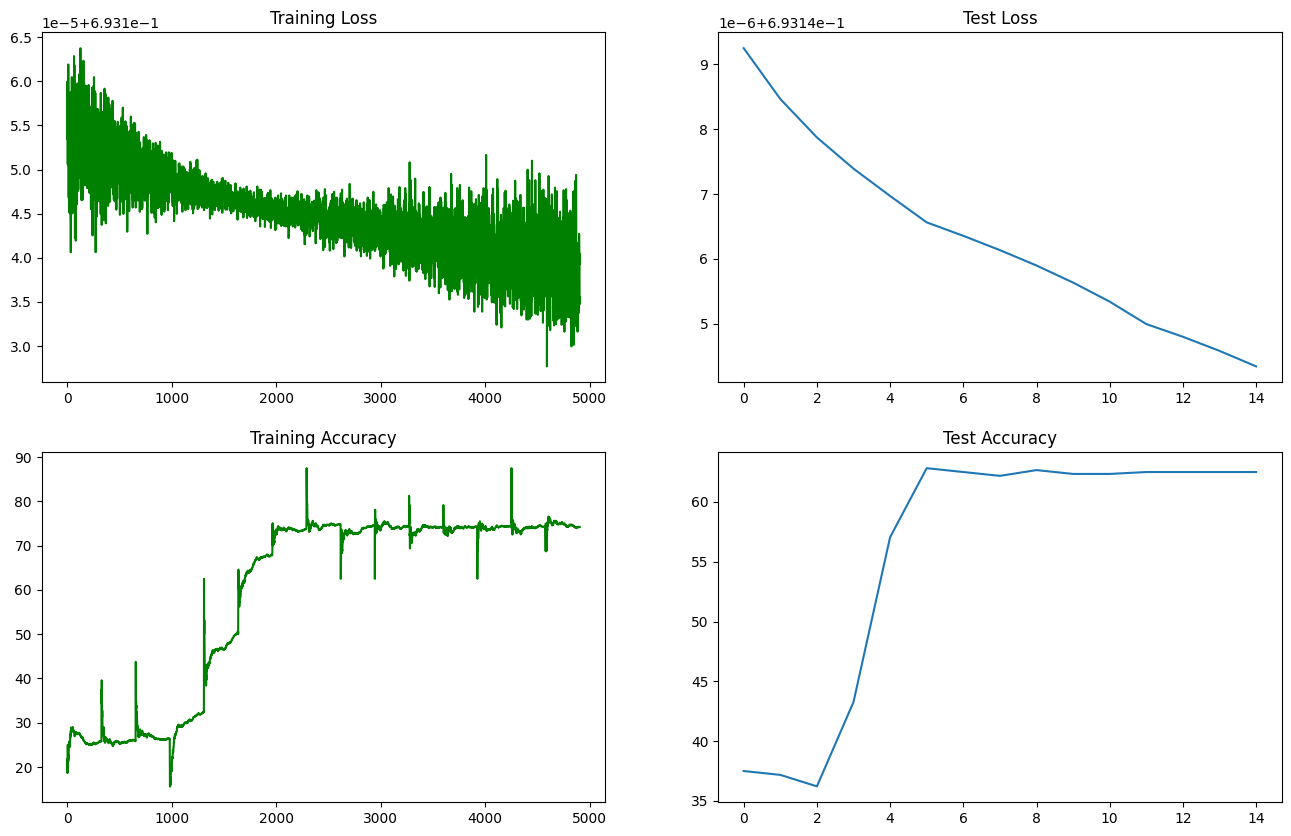

In [57]:
# for each loss which torch tensor on gpu; move it to cpu -> detach from current computation graph -> convert to numpy array
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

# plot the losses and accuracies during training and testing
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(train_losses1, color='green')
axs[0, 0].set_title('Training Loss')
axs[1, 0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
plt.show()


### Improve the Model using Data Augmentation

* Color Jitter
* Random Flip
* Random Rotation

In [62]:
# Defining the transformations
# Compose function chains together series of image transformations in the order they are listed
# Introduce Data Augmentation: color jitter, horizontal flip, rotation
train_transform = transforms.Compose([
    transforms.Resize(224),  # resize to 224x224
    transforms.CenterCrop(224), #crop center part of image to make it 224x224, ensuring images are uniform size and shape
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1), # change the brightness, contrast, saturation, and hue of an image
    transforms.RandomHorizontalFlip(p=0.5), # fip the image horizontally
    transforms.RandomRotation(10), # rotate the image by 10 degrees randomly
    transforms.ToTensor(), # convert imgs to pytorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalization; the mean and std for each of the 3 channels
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Dataset
# ImageFolder(): load images stored in a directory where images of each class are in separate subdirectories; 
# It assigns class indices based on alphabetical order of the directory names;
# It also applies the transformation defined above
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

# Preparing the data loaders: for efficient handling of data
# DataLoader(): wraps dataset to provide iterable over the  dataset. Allows for easy batch,
# shuffling, and loading data in parallel using multiprocessing workers 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True) # pin_memory: enable faster data transfer from CPU to CUDA
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True) # batch_size: 1; dataset is small/evaluating 1 image at at time

# Get the class names based on class indices found from ImageFolder()
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [64]:
# Initialize contrainers for losses and accuracies
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Initialize the model, optimizer, and scheduler
model_v2 = Net().to(device)
optimizer = torch.optim.SGD(model_v2.parameters(), lr=0.01, momentum=0.9)
# adjust the learning rate during training; helps in optimizing the learning process and could lead to better model performance
# optimizer and learning rate scheduler are tied, scheduler will adjust the learning rate according to its policy
# step_size: number of epochs after which the learning rate will be adjusted
# gamma: factor by which the learning rate will be adjusted; 0.5 is halved
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

# Train and evaluate the model for 15 epochs
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH: ", epoch)
    train(model_v2, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f'Current Learning Rate: {optimizer.state_dict()["param_groups"][0]["lr"]}')
    test(model_v2, device, test_loader)

EPOCH:  0


Loss=0.6931432485580444 Batch_id=326 Accuracy=73.41: 100%|██████████| 327/327 [01:44<00:00,  3.13it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6931 Accuracy: 390/624 (62%)

EPOCH:  1


Loss=0.6931319236755371 Batch_id=326 Accuracy=74.01: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6931 Accuracy: 390/624 (62%)

EPOCH:  2


Loss=0.6931414604187012 Batch_id=326 Accuracy=74.20: 100%|██████████| 327/327 [01:36<00:00,  3.40it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6931 Accuracy: 390/624 (62%)

EPOCH:  3


Loss=0.6930871605873108 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:35<00:00,  3.41it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6931 Accuracy: 390/624 (62%)

EPOCH:  4


Loss=0.6930778622627258 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:35<00:00,  3.42it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6931 Accuracy: 390/624 (62%)

EPOCH:  5


Loss=0.5512270927429199 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:37<00:00,  3.35it/s] 


Current Learning Rate: 0.005

Test set: Average loss: 0.6427 Accuracy: 390/624 (62%)

EPOCH:  6


Loss=0.2075132429599762 Batch_id=326 Accuracy=86.37: 100%|██████████| 327/327 [01:38<00:00,  3.32it/s]  


Current Learning Rate: 0.005

Test set: Average loss: 0.7270 Accuracy: 485/624 (78%)

EPOCH:  7


Loss=0.5321106910705566 Batch_id=326 Accuracy=90.94: 100%|██████████| 327/327 [01:36<00:00,  3.39it/s]  


Current Learning Rate: 0.005

Test set: Average loss: 0.6515 Accuracy: 503/624 (81%)

EPOCH:  8


Loss=0.12249017506837845 Batch_id=326 Accuracy=92.56: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s] 


Current Learning Rate: 0.005

Test set: Average loss: 0.4643 Accuracy: 526/624 (84%)

EPOCH:  9


Loss=0.2913033068180084 Batch_id=326 Accuracy=92.97: 100%|██████████| 327/327 [01:36<00:00,  3.38it/s]  


Current Learning Rate: 0.005

Test set: Average loss: 0.6767 Accuracy: 514/624 (82%)

EPOCH:  10


Loss=0.14387568831443787 Batch_id=326 Accuracy=93.58: 100%|██████████| 327/327 [01:38<00:00,  3.32it/s] 


Current Learning Rate: 0.005

Test set: Average loss: 0.5280 Accuracy: 509/624 (82%)

EPOCH:  11


Loss=0.09350285679101944 Batch_id=326 Accuracy=94.00: 100%|██████████| 327/327 [01:38<00:00,  3.34it/s] 


Current Learning Rate: 0.0025

Test set: Average loss: 0.6579 Accuracy: 508/624 (81%)

EPOCH:  12


Loss=0.1813117414712906 Batch_id=326 Accuracy=94.55: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]  


Current Learning Rate: 0.0025

Test set: Average loss: 0.5683 Accuracy: 522/624 (84%)

EPOCH:  13


Loss=0.2527640461921692 Batch_id=326 Accuracy=94.71: 100%|██████████| 327/327 [01:37<00:00,  3.34it/s]   


Current Learning Rate: 0.0025

Test set: Average loss: 0.4852 Accuracy: 540/624 (87%)

EPOCH:  14


Loss=0.08896012604236603 Batch_id=326 Accuracy=94.59: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s] 


Current Learning Rate: 0.0025

Test set: Average loss: 0.7240 Accuracy: 514/624 (82%)



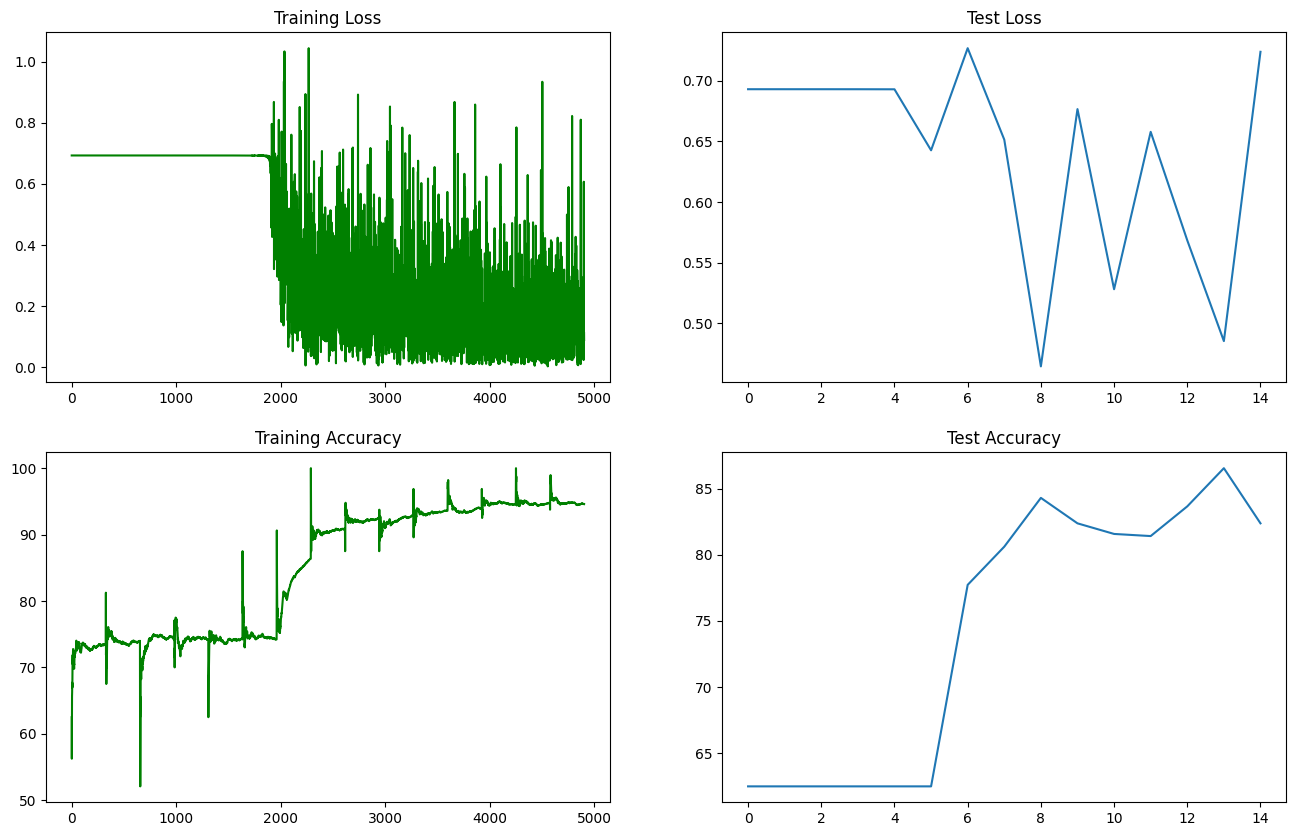

In [65]:
# for each loss which torch tensor on gpu; move it to cpu -> detach from current computation graph -> convert to numpy array
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

# plot the losses and accuracies during training and testing
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(train_losses1, color='green')
axs[0, 0].set_title('Training Loss')
axs[1, 0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
plt.show()

### Improve the Model using Batch Normalization
Reduces the internal covariate shift in the layers of the model


In [81]:
class Net_v2(nn.Module):
    def __init__(self):
        super(Net_v2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        
        # Convolution Blocks
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        
        # using kernel size of 1 helps reduce the feature maps in the z-direction by proposing combination of all feature maps
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(), 
            nn.BatchNorm2d(32)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        
        # Output block
        # Note: There should not be any batch normalization or dropout in the last layer of the model
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.convblockout = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False)
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)
    

EPOCH:  0


Loss=0.2155 Batch_id=326 Accuracy=90.83: 100%|██████████| 327/327 [01:40<00:00,  3.26it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.3924 Accuracy: 541/624 (87%)

EPOCH:  1


Loss=0.2337 Batch_id=326 Accuracy=93.67: 100%|██████████| 327/327 [01:40<00:00,  3.25it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.3633 Accuracy: 544/624 (87%)

EPOCH:  2


Loss=0.1120 Batch_id=326 Accuracy=94.80: 100%|██████████| 327/327 [01:44<00:00,  3.11it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.4428 Accuracy: 522/624 (84%)

EPOCH:  3


Loss=0.2015 Batch_id=326 Accuracy=94.71: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.6640 Accuracy: 507/624 (81%)

EPOCH:  4


Loss=0.0263 Batch_id=326 Accuracy=95.37: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.3003 Accuracy: 559/624 (90%)

EPOCH:  5


Loss=0.0047 Batch_id=326 Accuracy=95.18: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.4958 Accuracy: 522/624 (84%)

EPOCH:  6


Loss=0.0304 Batch_id=326 Accuracy=96.33: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.4130 Accuracy: 541/624 (87%)

EPOCH:  7


Loss=0.0209 Batch_id=326 Accuracy=96.20: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.5047 Accuracy: 523/624 (84%)

EPOCH:  8


Loss=0.0580 Batch_id=326 Accuracy=96.41: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.5193 Accuracy: 520/624 (83%)

EPOCH:  9


Loss=0.0303 Batch_id=326 Accuracy=96.35: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.5387 Accuracy: 518/624 (83%)

EPOCH:  10


Loss=0.0536 Batch_id=326 Accuracy=96.67: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6552 Accuracy: 514/624 (82%)

EPOCH:  11


Loss=0.1594 Batch_id=326 Accuracy=96.73: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.5622 Accuracy: 518/624 (83%)

EPOCH:  12


Loss=0.0311 Batch_id=326 Accuracy=96.90: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.4828 Accuracy: 529/624 (85%)

EPOCH:  13


Loss=0.0046 Batch_id=326 Accuracy=97.02: 100%|██████████| 327/327 [01:45<00:00,  3.09it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.3454 Accuracy: 552/624 (88%)

EPOCH:  14


Loss=0.0028 Batch_id=326 Accuracy=96.83: 100%|██████████| 327/327 [01:46<00:00,  3.08it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.5336 Accuracy: 526/624 (84%)



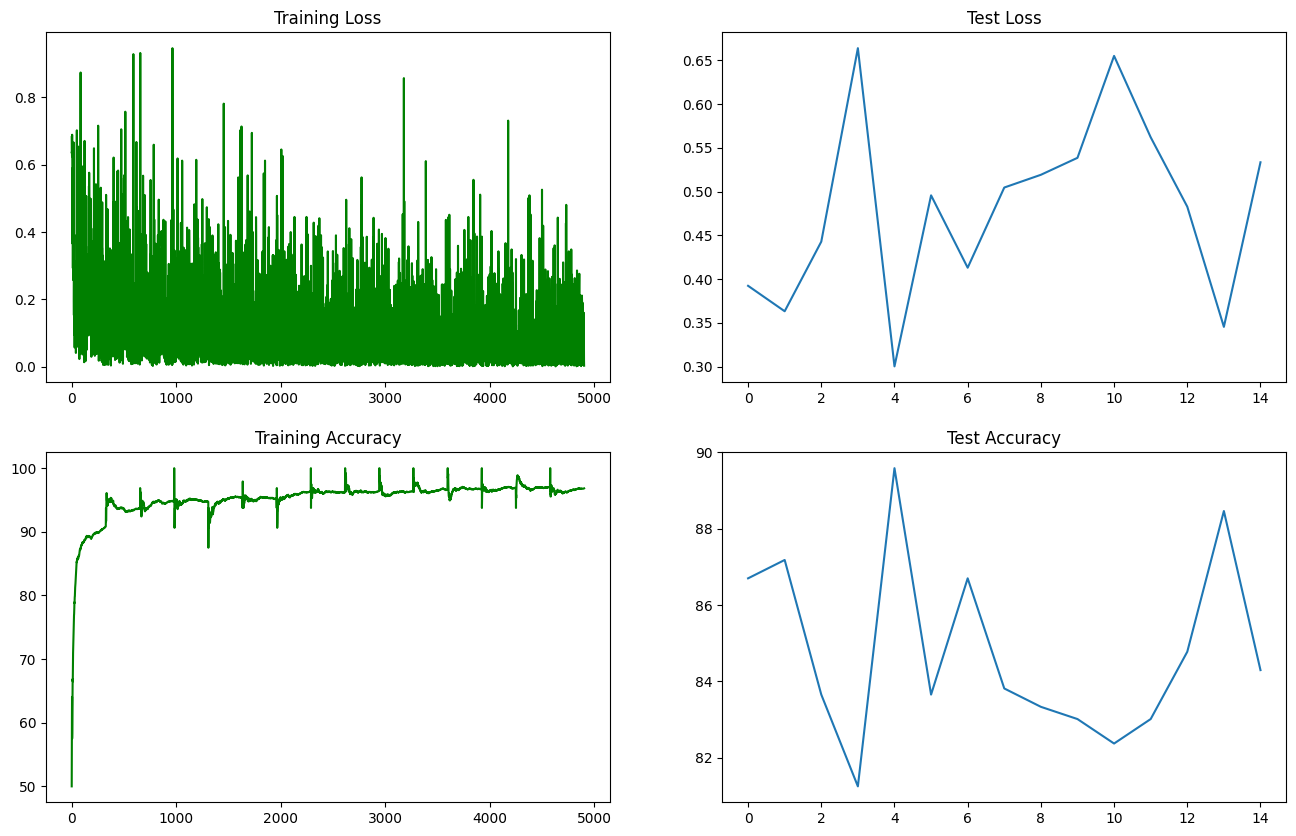

In [87]:
# Initialize contrainers for losses and accuracies
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Initialize the model, optimizer, and scheduler
model_v3 = Net_v2().to(device)
optimizer = torch.optim.SGD(model_v3.parameters(), lr=0.01, momentum=0.9)
# adjust the learning rate during training; helps in optimizing the learning process and could lead to better model performance
# optimizer and learning rate scheduler are tied, scheduler will adjust the learning rate according to its policy
# step_size: number of epochs after which the learning rate will be adjusted
# gamma: factor by which the learning rate will be adjusted; 0.5 is halved
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

# Train and evaluate the model for 15 epochs
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH: ", epoch)
    train(model_v3, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f'Current Learning Rate: {optimizer.state_dict()["param_groups"][0]["lr"]}')
    test(model_v3, device, test_loader)
    
# for each loss which torch tensor on gpu; move it to cpu -> detach from current computation graph -> convert to numpy array
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

# plot the losses and accuracies during training and testing
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(train_losses1, color='green')
axs[0, 0].set_title('Training Loss')
axs[1, 0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [88]:
# Look at the summary of the model after including batch normalization: should be increase in model size and learnable paramters
summary(model_v3, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             ReLU-14           [-1, 10,

### Improve the Model using Regularization
https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058

In [90]:
def train_with_reg(model, device, train_loader, optimizer, epoch):
    # Training rountine for 1 epoch
    # set the model to training mode; enables dropout and batch normalization to behave appropriately during training
    model.train()
    # initialize progress bar using tqdm that wraps around the training data loader
    pbar = tqdm(train_loader)
    # Initialize the correct and processed counter
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # move the data and target to specified device; ensure that the model and the data are on the same device during training
        data, target = data.to(device), target.to(device)
        # initalize the gradient(clear gradient from last step; otherwise gradient would accumulate from previous steps)
        optimizer.zero_grad()
        # forward pass
        y_pred = model(data)
        # calculate the loss; using negative log-likelihood loss between prediction and target class
        loss = F.nll_loss(y_pred, target)
        
        # apply L1 regularization
        l1_penalty = torch.nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            if param.requires_grad:
                reg_loss += torch.sum(torch.abs(param))
        factor = 0.01  # Lambda
        loss += factor * reg_loss
        
        # record the training loss for this batch
        train_losses.append(loss)
        # backward pass
        loss.backward()
        # update the weights using the optimizer
        optimizer.step()
        # calculate the accuracy of the current batch
        pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log probability
        # note: eq() computes element wise equality between two tensors and returns a tensor of the same shape as the inputs
        # note: view_as() reshape tensor to have same size as another tensor; useful for aligning tensors to have same shape during element-wise oeprations
        # note: item(): returns a one element tensor as a standard python number; used for logging, etc.
        correct += pred.eq(target.view_as(pred)).sum().item() # get the number of correct predictions
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

EPOCH:  0


Loss=2.1227 Batch_id=326 Accuracy=88.15: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.7472 Accuracy: 389/624 (62%)

EPOCH:  1


Loss=1.2970 Batch_id=326 Accuracy=89.32: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]


Current Learning Rate: 0.01

Test set: Average loss: 1.7672 Accuracy: 390/624 (62%)

EPOCH:  2


Loss=1.0088 Batch_id=326 Accuracy=89.66: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]


Current Learning Rate: 0.01

Test set: Average loss: 1.6811 Accuracy: 390/624 (62%)

EPOCH:  3


Loss=1.0601 Batch_id=326 Accuracy=87.54: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.7802 Accuracy: 391/624 (63%)

EPOCH:  4


Loss=1.0763 Batch_id=326 Accuracy=85.76: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]


Current Learning Rate: 0.01

Test set: Average loss: 0.7180 Accuracy: 390/624 (62%)

EPOCH:  5


Loss=0.8133 Batch_id=326 Accuracy=74.18: 100%|██████████| 327/327 [01:46<00:00,  3.06it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6861 Accuracy: 390/624 (62%)

EPOCH:  6


Loss=0.6527 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6923 Accuracy: 390/624 (62%)

EPOCH:  7


Loss=0.7713 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6940 Accuracy: 390/624 (62%)

EPOCH:  8


Loss=0.5838 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.05it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6820 Accuracy: 390/624 (62%)

EPOCH:  9


Loss=0.5883 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6740 Accuracy: 390/624 (62%)

EPOCH:  10


Loss=0.7395 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.04it/s]


Current Learning Rate: 0.005

Test set: Average loss: 0.6726 Accuracy: 390/624 (62%)

EPOCH:  11


Loss=0.9013 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:47<00:00,  3.03it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.7774 Accuracy: 390/624 (62%)

EPOCH:  12


Loss=0.5203 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:48<00:00,  3.03it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.7301 Accuracy: 390/624 (62%)

EPOCH:  13


Loss=0.6764 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:48<00:00,  3.02it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.7132 Accuracy: 390/624 (62%)

EPOCH:  14


Loss=0.6752 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [01:48<00:00,  3.00it/s]


Current Learning Rate: 0.0025

Test set: Average loss: 0.6756 Accuracy: 390/624 (62%)



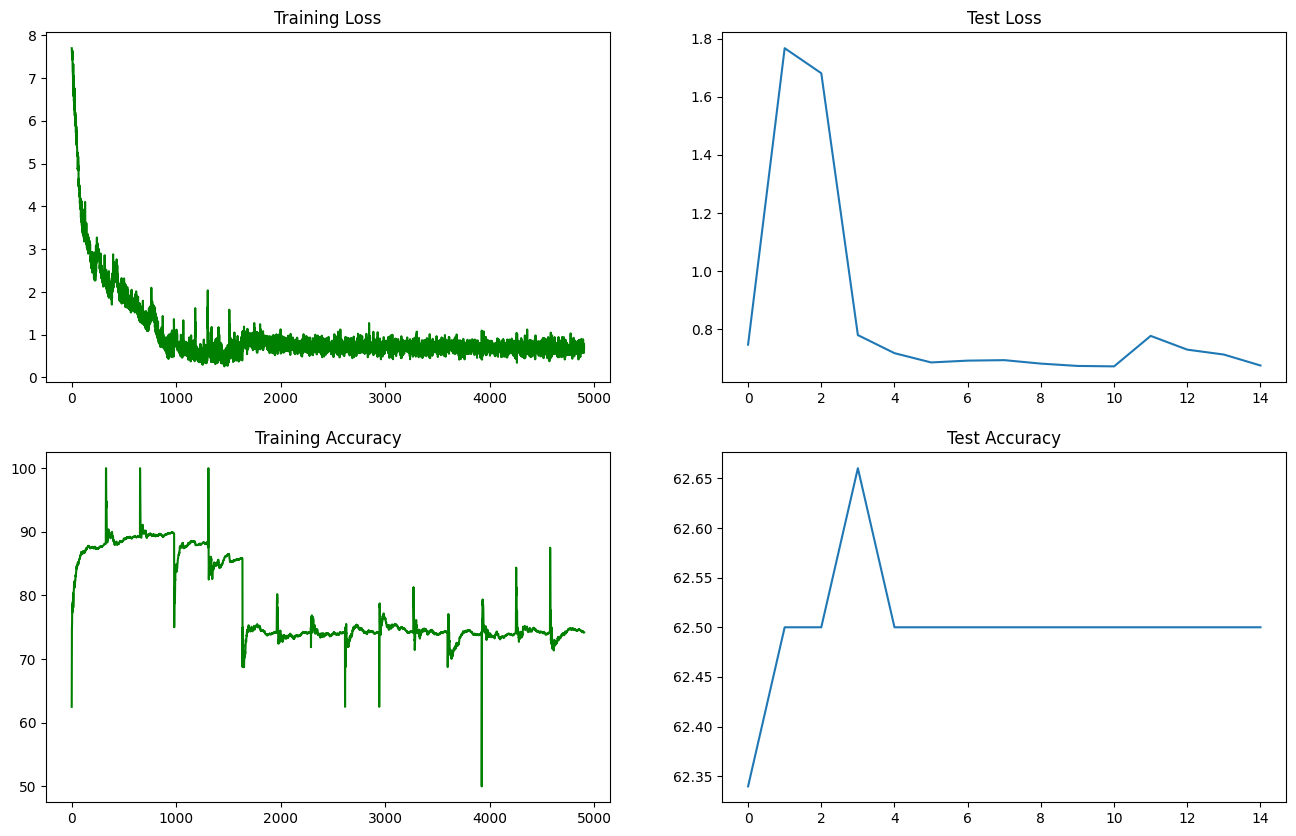

In [91]:
# Initialize contrainers for losses and accuracies
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Initialize the model, optimizer, and scheduler
model_v4 = Net_v2().to(device)
optimizer = torch.optim.SGD(model_v4.parameters(), lr=0.01, momentum=0.9)
# adjust the learning rate during training; helps in optimizing the learning process and could lead to better model performance
# optimizer and learning rate scheduler are tied, scheduler will adjust the learning rate according to its policy
# step_size: number of epochs after which the learning rate will be adjusted
# gamma: factor by which the learning rate will be adjusted; 0.5 is halved
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

# Train and evaluate the model for 15 epochs
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH: ", epoch)
    train_with_reg(model_v4, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f'Current Learning Rate: {optimizer.state_dict()["param_groups"][0]["lr"]}')
    test(model_v4, device, test_loader)
    
# for each loss which torch tensor on gpu; move it to cpu -> detach from current computation graph -> convert to numpy array
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

# plot the losses and accuracies during training and testing
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(train_losses1, color='green')
axs[0, 0].set_title('Training Loss')
axs[1, 0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
plt.show()

#### Resources
- Computer Vision Projects with PyTorch: Design and Develop Production-Grade Models by Akshay Kulkarni, Adarsha Shivananda, Nitin Ranjan Sharma
- https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058
- https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81